# Zillow Clustering Project 

##### Imports:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Wrangle file to acquire and clean Zillow data
import wrangle_zillow as wr
import sklearn.preprocessing

# Explore file
import explore as ex
import explore_evaluate as ee
from sklearn.cluster import KMeans

# Models
import zillow_models as zm

## Acquire:

In [2]:
zillow = wr.wrangle_zillow()
zillow.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,heatingorsystemdesc,county
0,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,1998.0,1023282.0,0.025595,2017-01-01,None,Orange
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,1967.0,464000.0,0.055619,2017-01-01,None,Ventura
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,1962.0,564778.0,0.005383,2017-01-01,None,Orange


In [3]:
zillow['abs_logerr'] = zillow.logerror.apply(lambda x: x if x >= 0 else -x)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70910 entries, 0 to 77380
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   70910 non-null  float64
 1   bedroomcnt                    70910 non-null  float64
 2   calculatedfinishedsquarefeet  70910 non-null  float64
 3   fips                          70910 non-null  float64
 4   latitude                      70910 non-null  float64
 5   longitude                     70910 non-null  float64
 6   yearbuilt                     70910 non-null  float64
 7   taxvaluedollarcnt             70910 non-null  float64
 8   logerror                      70910 non-null  float64
 9   transactiondate               70910 non-null  object 
 10  heatingorsystemdesc           70910 non-null  object 
 11  county                        70910 non-null  object 
 12  abs_logerr                    70910 non-null  float64
dtypes

### Train, Validate, Test Split

In [4]:
train, validate, test = wr.train_validate_test_split(zillow)
print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  553098
validate observations:  184366
test observations:  184366


## Explore:

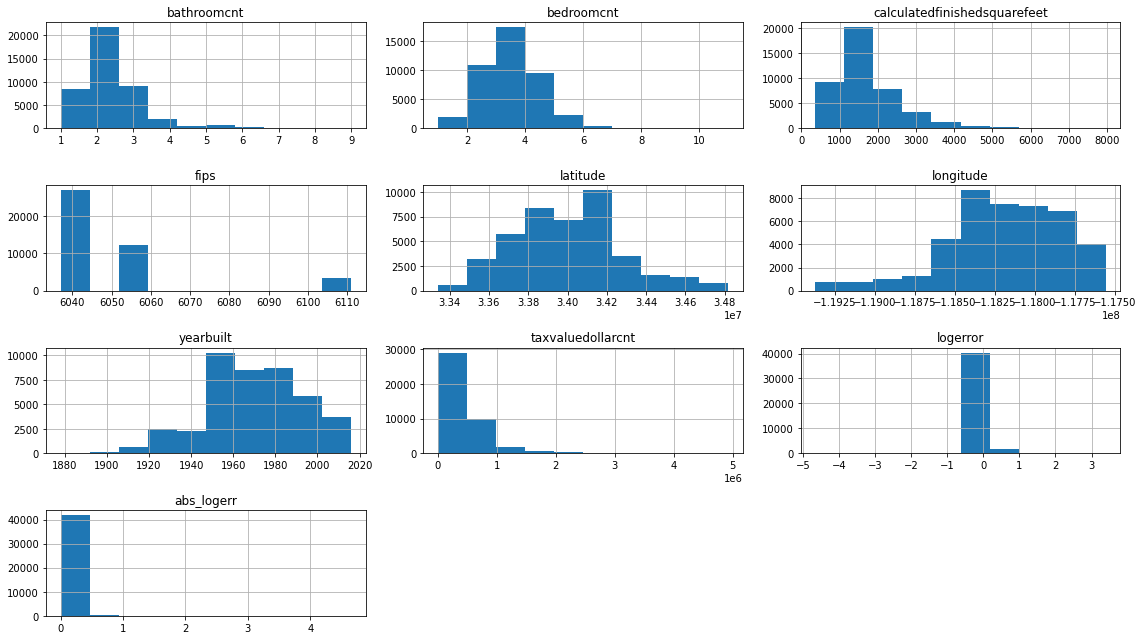

In [5]:
train.hist(figsize=(16,9))
plt.tight_layout()
plt.show()

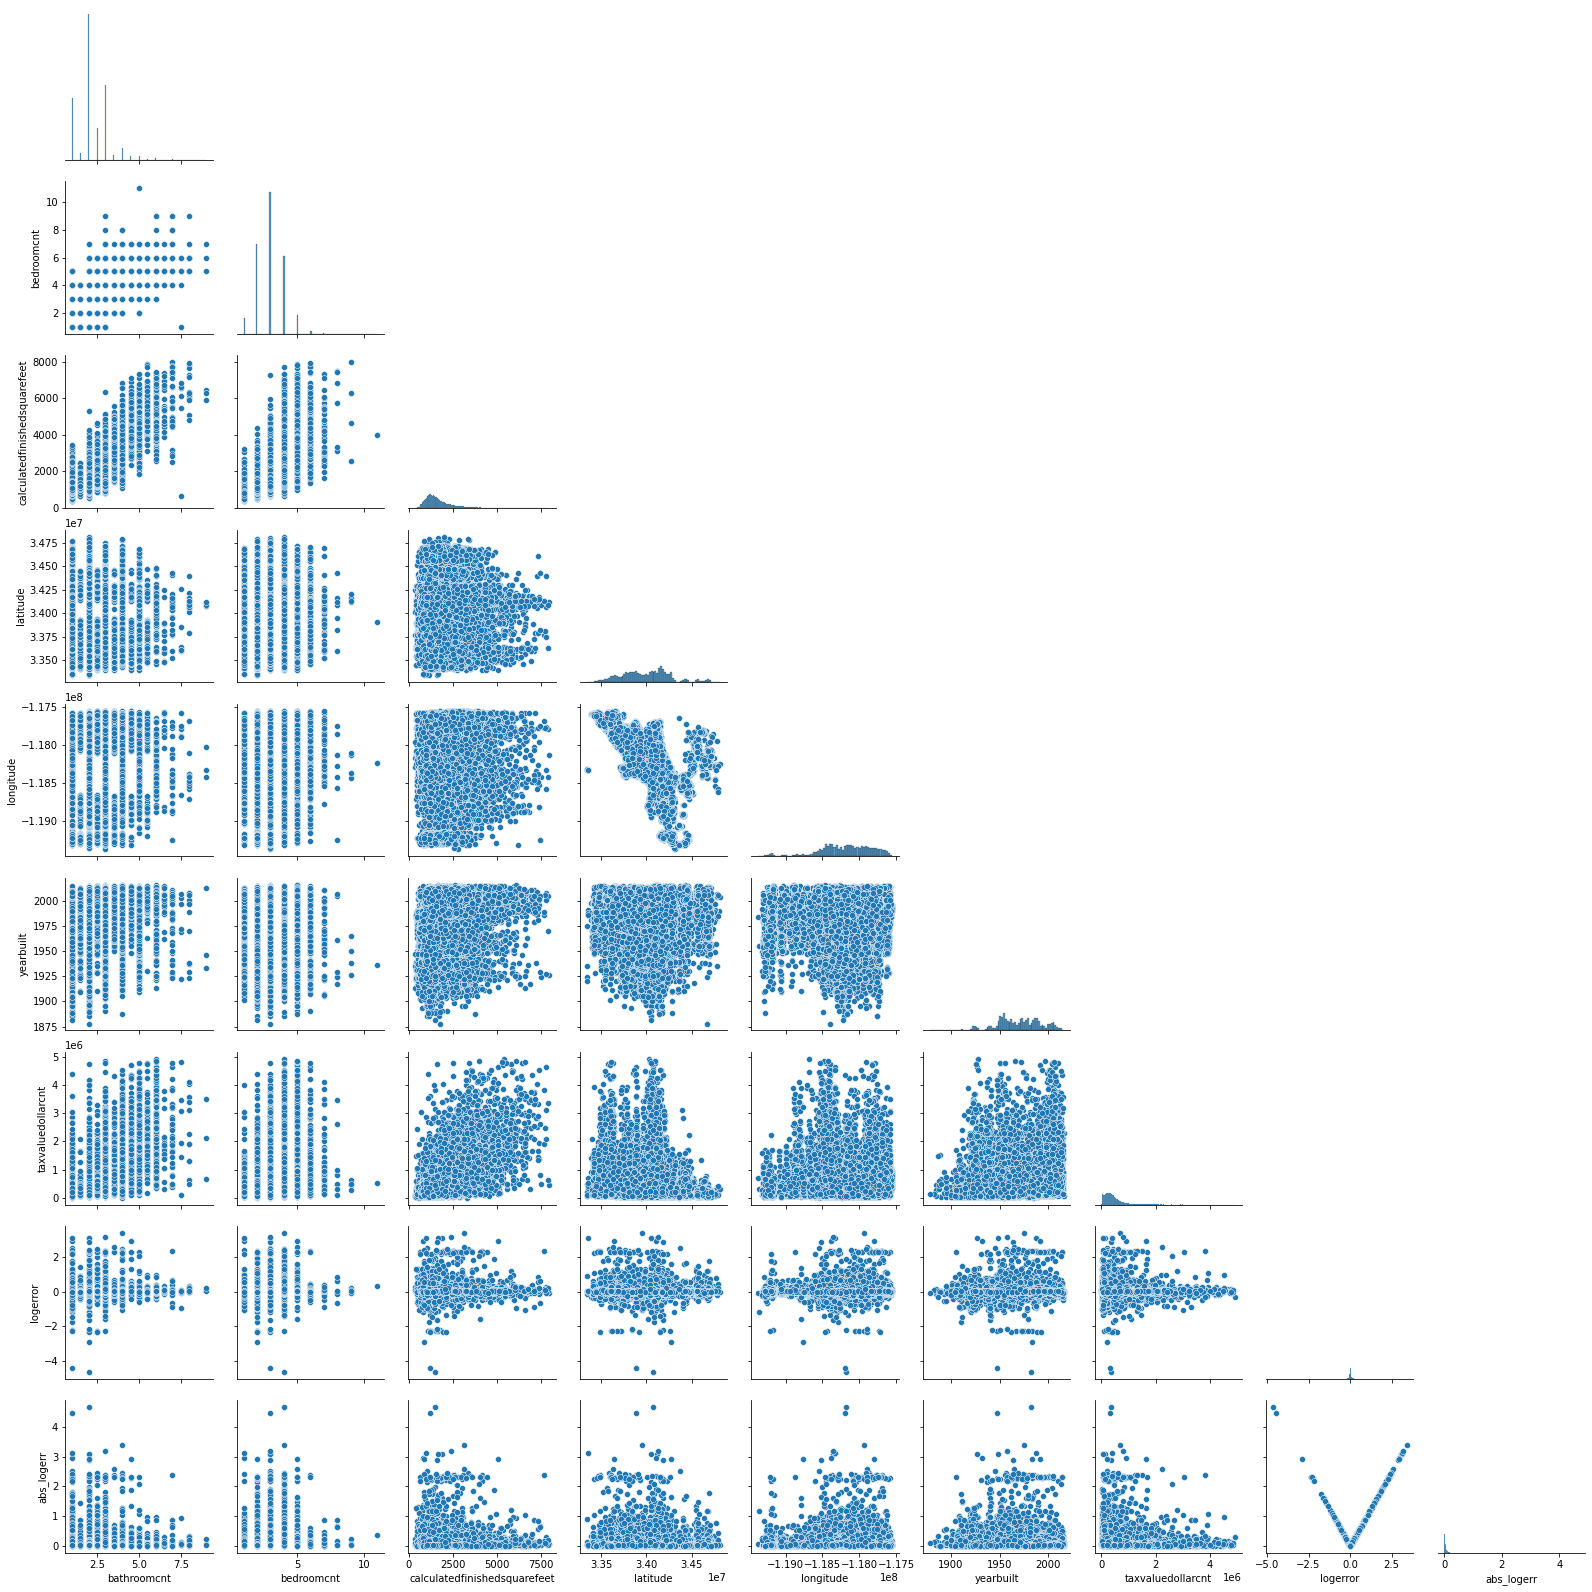

In [6]:
sns.pairplot(train.drop(columns='fips'), corner=True)
plt.show()

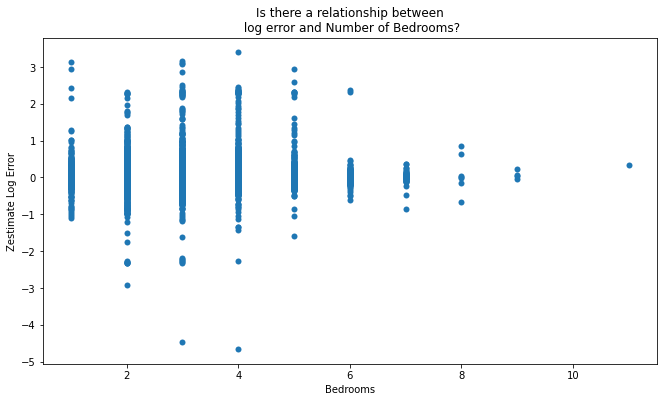

In [7]:
# Plot of log error vs number of bedrooms
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="bedroomcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Number of Bedrooms?')
plt.xlabel('Bedrooms')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

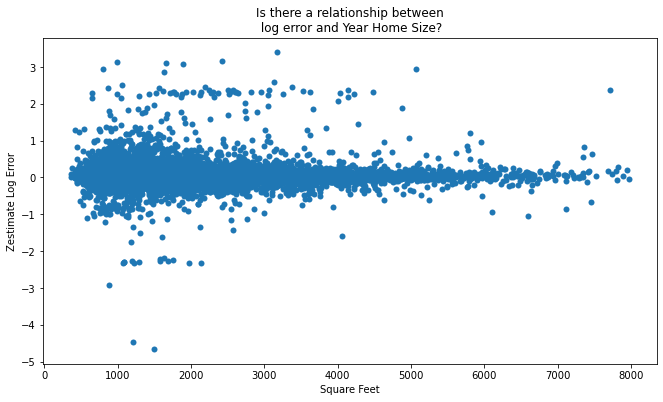

In [8]:
# Plot of log error vs square feet
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year Home Size?')
plt.xlabel('Square Feet')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

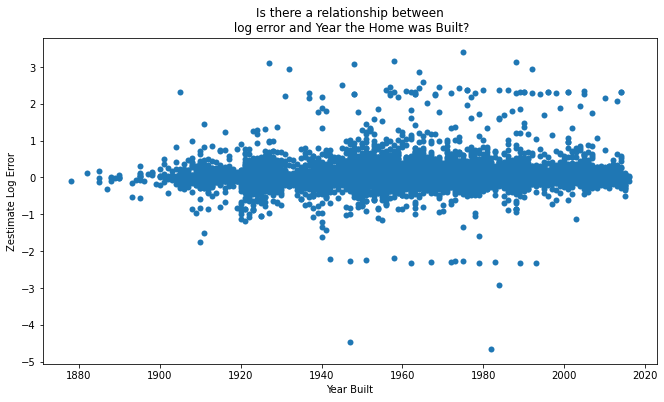

In [9]:
# Plot of log error vs year built
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="yearbuilt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year the Home was Built?')
plt.xlabel('Year Built')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

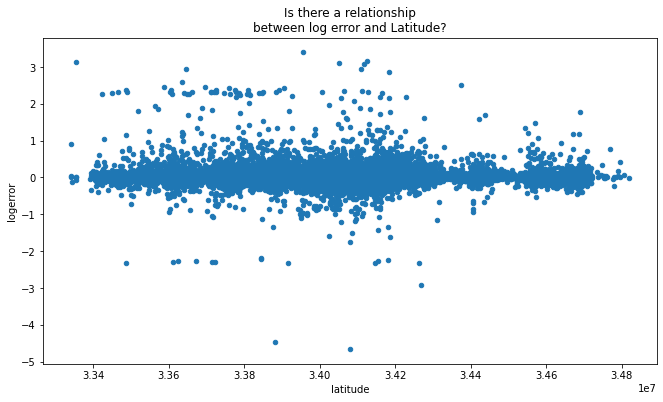

In [10]:
train.plot.scatter(
    x="latitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Latitude?',
    figsize=(11, 6)
)
plt.show()

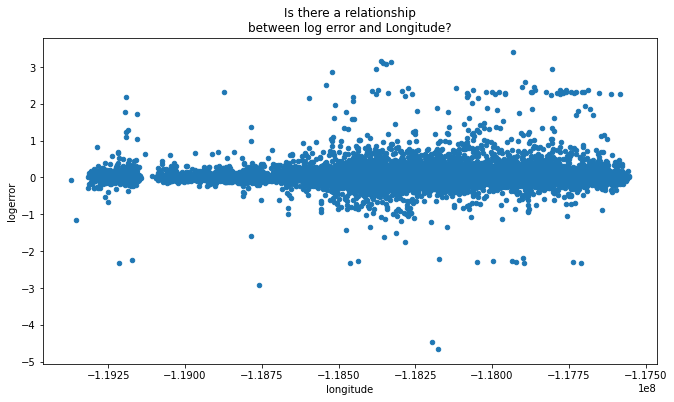

In [11]:
train.plot.scatter(
    x="longitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Longitude?',
    figsize=(11, 6),
)
plt.show()

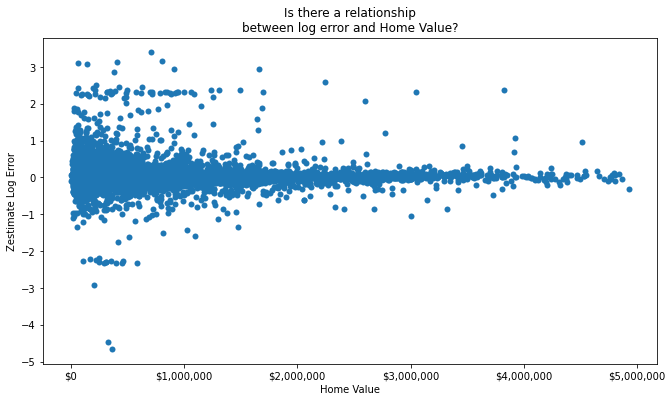

In [12]:
# Plot of log error vs home value
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="taxvaluedollarcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship\nbetween log error and Home Value?')
plt.xlabel('Home Value')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('${:,.0f}'.format) 

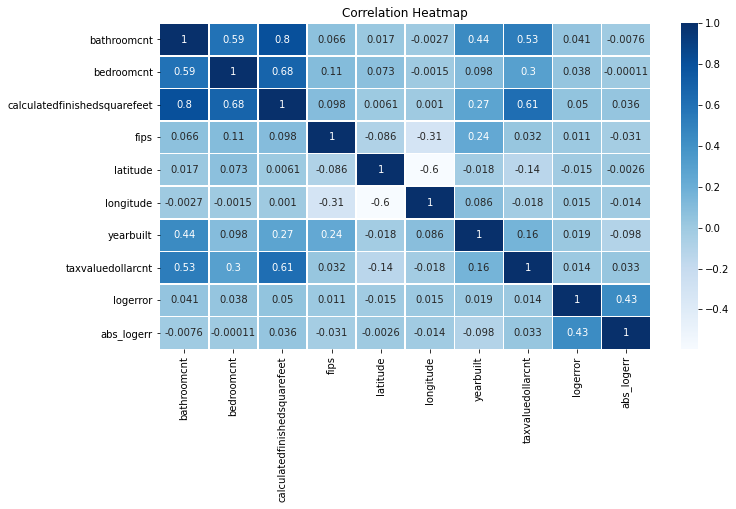

In [13]:
plt.figure(figsize=(11,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True, linewidth=0.5)
plt.title('Correlation Heatmap')
plt.show()

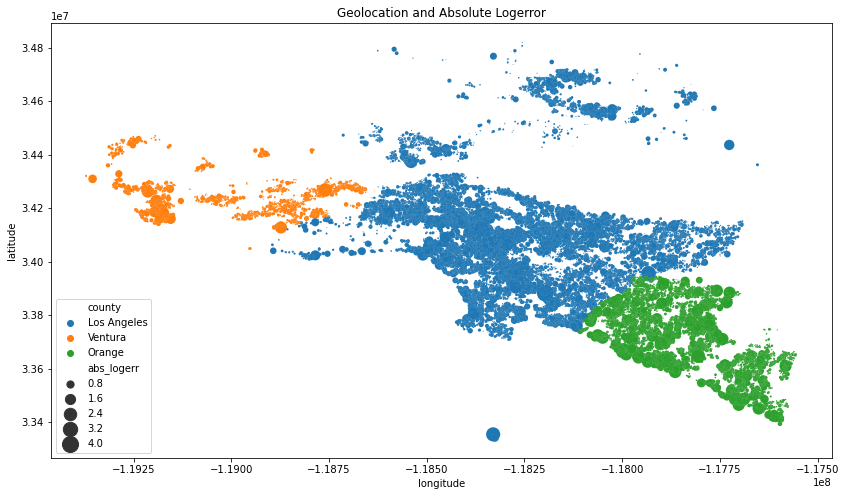

In [14]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

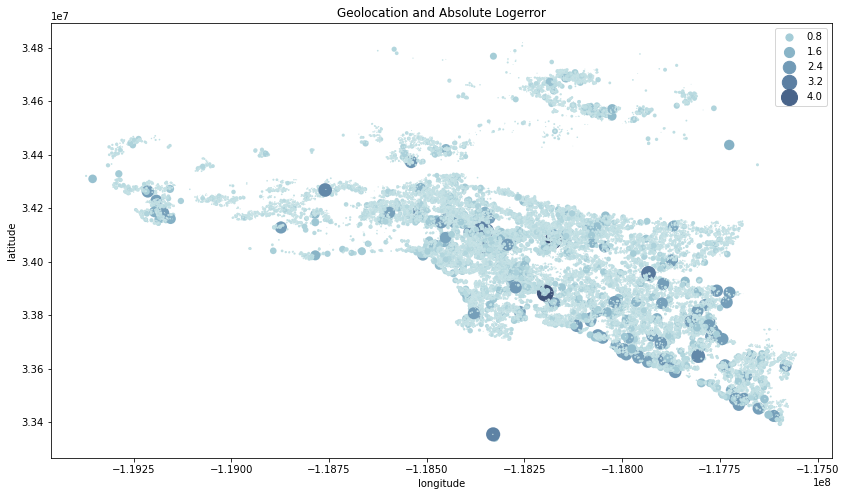

In [15]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

##### Takeaways:
- There seems to be bands of clusters in log error vs above categories
- Lat Long seems to be the most promising to explore via clustering
- Then potentially sqft and beadroom/bathroom count

### Statistics

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42546 entries, 28420 to 47816
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42546 non-null  float64
 1   bedroomcnt                    42546 non-null  float64
 2   calculatedfinishedsquarefeet  42546 non-null  float64
 3   fips                          42546 non-null  float64
 4   latitude                      42546 non-null  float64
 5   longitude                     42546 non-null  float64
 6   yearbuilt                     42546 non-null  float64
 7   taxvaluedollarcnt             42546 non-null  float64
 8   logerror                      42546 non-null  float64
 9   transactiondate               42546 non-null  object 
 10  heatingorsystemdesc           42546 non-null  object 
 11  county                        42546 non-null  object 
 12  abs_logerr                    42546 non-null  float64
dt

### Scaling

In [17]:
# Scale the datasets
column = ['fips', 'transactiondate', 'heatingorsystemdesc', 'county', ]
scaler = sklearn.preprocessing.MinMaxScaler()
cols = train.drop(columns=column).columns.tolist()

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

train_scaled = train_scaled.drop(columns=column)
validate_scaled = validate_scaled.drop(columns=column)
test_scaled = test_scaled.drop(columns=column)

In [18]:
train_scaled.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,yearbuilt,taxvaluedollarcnt,logerror,abs_logerr
28420,0.125,0.1,0.074901,0.573464,0.502856,0.826087,0.028647,0.580490,0.00376
66765,0.000,0.1,0.147043,0.441294,0.594425,0.224638,0.027425,0.585111,0.01175


## Initial Regression Models

In [19]:
X_train, y_train, X_validate, y_validate, X_test, y_test = zm.zillow_xy(train_scaled.drop(columns='abs_logerr'), 
                                                                        validate_scaled.drop(columns='abs_logerr'), 
                                                                        test_scaled.drop(columns='abs_logerr'))

In [20]:
compare = zm.model_compare(X_train, y_train, X_validate, y_validate)
compare

,model,RMSE Train,RMSE Validate,r^2 Validate
0,Baseline (mean),0.02051,0.02084,0.000000
1,OLS Regressor,0.01841,0.01986,0.092470
2,Lasso: Alpha 1,0.02051,0.02084,0.000000
3,GLM Normal,0.01844,0.01989,0.088893
4,GLM Poisson,0.01846,0.01990,0.087981
5,Polynomial 2deg,0.01782,0.02032,0.049324
6,Polynomial 3deg,0.01587,0.02151,-0.064971


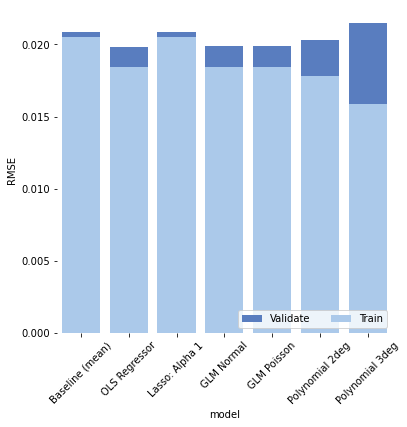

In [21]:
# Visual representation of the above chart:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("muted")
sns.barplot(x="model", y="RMSE Validate", data=compare,
            label="Validate", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="model", y="RMSE Train", data=compare,
            label="Train", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.ylabel('RMSE')
plt.xticks(rotation = 45)
sns.despine(left=True, bottom=True)

In [22]:
#Recursive Feature Elimination Ranking
ee.rfe_output(X_train, y_train)

,Var,Rank
0,bathroomcnt,7
1,bedroomcnt,3
2,calculatedfinishedsquarefeet,5
3,latitude,6
4,longitude,8
5,yearbuilt,2
6,taxvaluedollarcnt,4
7,abs_logerr,1


## Clustering: K-Means

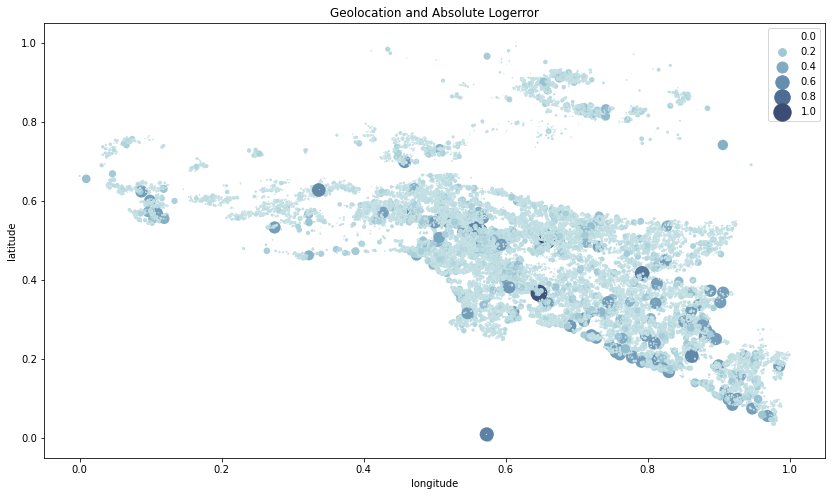

In [24]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train_scaled)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

In [25]:
def find_k(train_scaled, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

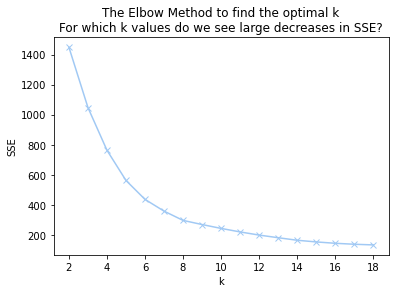

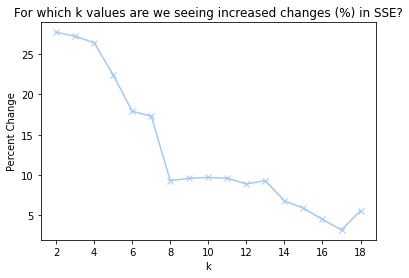

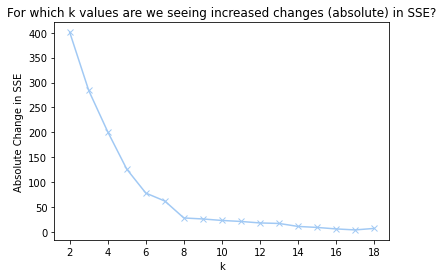

,k,sse,delta,pct_delta
0,2,1448.745579,401.0,27.7
1,3,1047.310254,284.0,27.2
2,4,762.848242,201.0,26.4
3,5,561.758614,126.0,22.4
4,6,435.704433,78.0,17.9
5,7,357.509959,62.0,17.3
6,8,295.795910,28.0,9.3
7,9,268.187982,26.0,9.6
8,10,242.424503,23.0,9.7
9,11,218.988508,21.0,9.6


In [27]:
cluster_vars = ['latitude', 'longitude', 'abs_logerr']
cluster_name = 'latlong_err_cluster'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df